Data source: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

## 1. Green Taxi Service Area Graph Generation

- **Load and Filter Taxi Zones**:  
  - Reads NYC taxi zone shapefiles.
  - Filters zones to include only those in Manhattan.
  - Calculates centroids (latitude and longitude) for each zone.

- **Select and Reassign Nodes**:  
  - Filters specific zones(**Green Taxi Service Zone**) by `LocationID`.
  - Assigns new sequential IDs to the filtered zones for easier graph representation.

- **Construct Graph**:  
  - Builds a spatial graph using `networkx`.
  - Nodes represent taxi zones, and edges are added between zones with shared boundaries.
  - Geodesic distances between centroids are calculated as edge weights.

- **Visualize Graph**:  
  - Plots the graph with:
    - Nodes labeled by their sequential IDs.
    - Edges annotated with their geodesic distances.

- **Generate Adjacency Matrix**:  
  - Creates a binary adjacency matrix indicating connections between nodes.
  - Saves the matrix as a CSV file.

- **Compute Shortest Distance Matrix**:  
  - Calculates all-pairs shortest paths using Dijkstra's algorithm.
  - Generates a shortest distance matrix.
  - Saves the matrix as a CSV file.


/tmp/ipykernel_114320/504220965.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  manhattan_gdf['centroid'] = manhattan_gdf.geometry.centroid
/tmp/ipykernel_114320/504220965.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  manhattan_gdf['latitude'] = manhattan_gdf.centroid.y
/tmp/ipykernel_114320/504220965.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  manhattan_gdf['longitude'] = manhattan_gdf.centroid.x


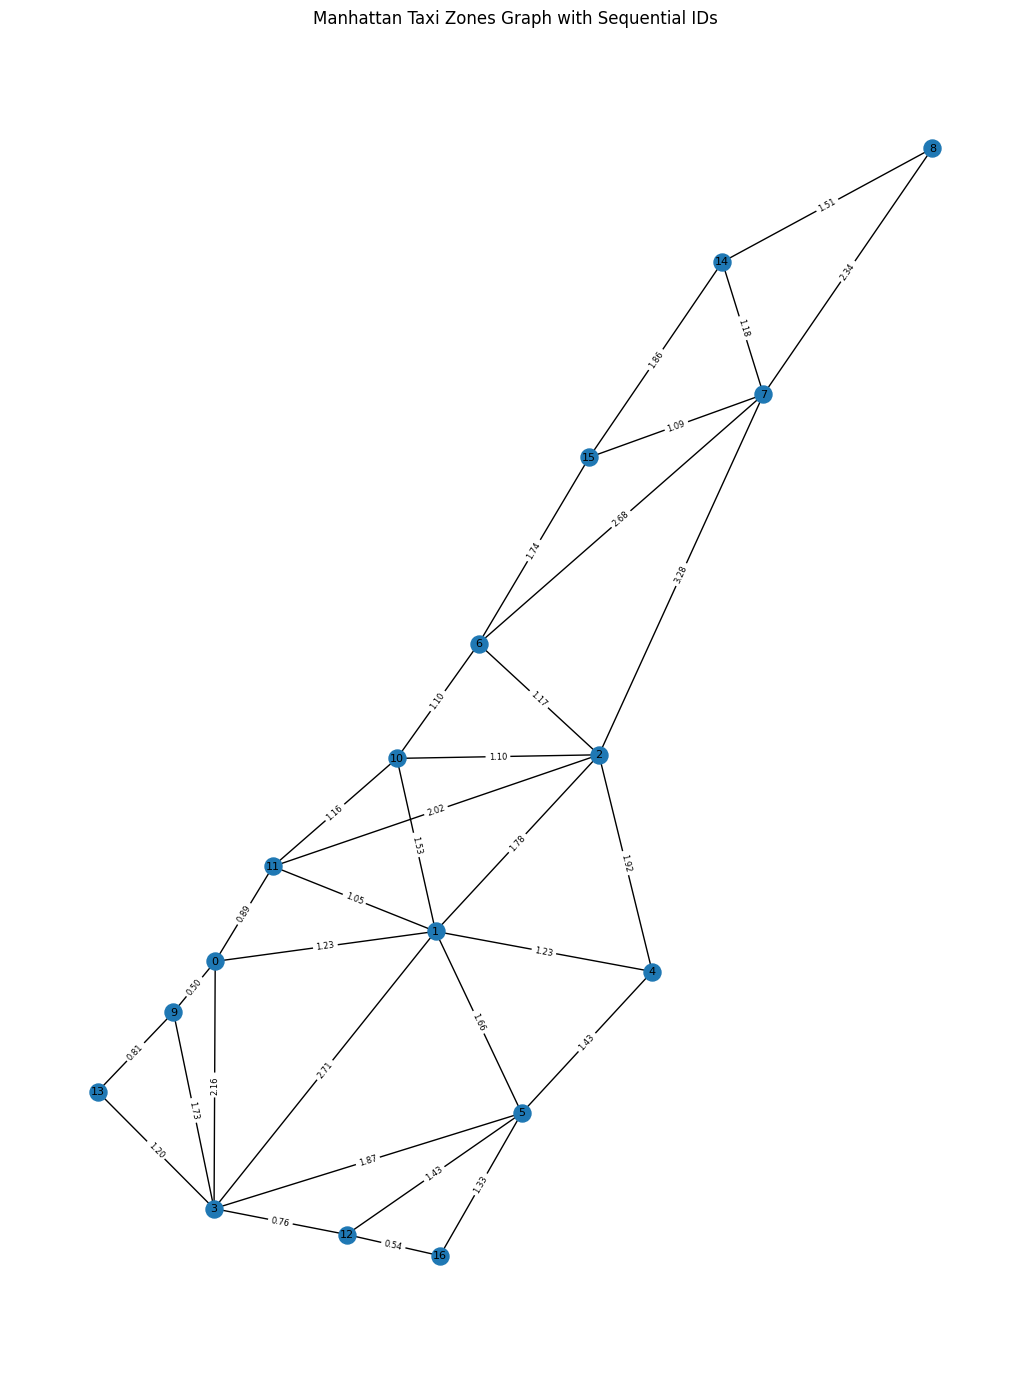

Binary adjacency matrix saved to 'data/processed/graph/adjacency_matrix_binary.csv'
Shortest distance matrix saved to 'data/processed/graph/shortest_distance_matrix.csv'


In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt

# Load the taxi zones shapefile from the NYC Taxi dataset
taxi_zones_gdf = gpd.read_file('data/raw/taxi_zones/taxi_zones.shp')

# Filter to only include Manhattan zones
manhattan_gdf = taxi_zones_gdf[taxi_zones_gdf['borough'] == 'Manhattan']

# Convert the coordinate reference system to WGS84 (EPSG:4326)
manhattan_gdf = manhattan_gdf.to_crs(epsg=4326)

# Calculate centroids and extract latitude and longitude
manhattan_gdf['centroid'] = manhattan_gdf.geometry.centroid
manhattan_gdf['latitude'] = manhattan_gdf.centroid.y
manhattan_gdf['longitude'] = manhattan_gdf.centroid.x

# Select nodes and reassign sequential IDs (0-16)
nodes_to_keep = [74, 75, 43, 166, 41, 244, 42, 24, 116, 236, 152, 243, 263, 127, 120, 238, 151]
gdf_wgs84_filtered = manhattan_gdf[manhattan_gdf['LocationID'].isin(nodes_to_keep)].reset_index(drop=True)
location_id_map = {original_id: new_id for new_id, original_id in enumerate(gdf_wgs84_filtered['LocationID'])}
gdf_wgs84_filtered['new_id'] = gdf_wgs84_filtered['LocationID'].map(location_id_map)

# Create a graph and add nodes with new sequential IDs
graph = nx.Graph()
for _, row in gdf_wgs84_filtered.iterrows():
    graph.add_node(row['new_id'], zone=row['zone'], latitude=row['latitude'], longitude=row['longitude'])

# Add edges based on shared boundaries and calculate geodesic distances
for i, zone_1 in gdf_wgs84_filtered.iterrows():
    for j, zone_2 in gdf_wgs84_filtered.iterrows():
        if i < j and zone_1.geometry.intersects(zone_2.geometry):
            distance = round(geodesic((zone_1['latitude'], zone_1['longitude']), 
                                      (zone_2['latitude'], zone_2['longitude'])).kilometers, 2)
            graph.add_edge(zone_1['new_id'], zone_2['new_id'], weight=distance)

# Plot the graph
plt.figure(figsize=(10.1, 13.4))
pos = {node: (data['longitude'], data['latitude']) for node, data in graph.nodes(data=True)}
nx.draw(graph, pos, with_labels=True, node_size=150, font_size=8)
nx.draw_networkx_edge_labels(graph, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in graph.edges(data=True)}, font_size=6)
plt.title('Manhattan Taxi Zones Graph with Sequential IDs')
plt.show()

# 1. Binary adjacency matrix
binary_adj_matrix = nx.to_numpy_array(graph, weight=None).astype(int)
binary_adj_matrix_df = pd.DataFrame(binary_adj_matrix, index=range(len(location_id_map)), columns=range(len(location_id_map)))
binary_adj_matrix_df.to_csv('data/processed/graph/adjacency_matrix_binary.csv')
print("Binary adjacency matrix saved to 'data/processed/graph/adjacency_matrix_binary.csv'")

# 2. Shortest distance matrix (all-pairs shortest paths)
shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(graph, weight='weight'))
node_count = len(location_id_map)
shortest_distance_matrix = np.full((node_count, node_count), np.inf)

# Fill shortest distance matrix with computed distances
for i, lengths in shortest_path_lengths.items():
    for j, dist in lengths.items():
        shortest_distance_matrix[i, j] = round(dist, 2)

shortest_distance_matrix_df = pd.DataFrame(shortest_distance_matrix, index=range(node_count), columns=range(node_count))
shortest_distance_matrix_df.to_csv('data/processed/graph/shortest_distance_matrix.csv')
print("Shortest distance matrix saved to 'data/processed/graph/shortest_distance_matrix.csv'")


## 2. Taxi Zone and ZIP Zone Comparison

- **Load Taxi Zones Data**:  
  - Reads the NYC taxi zones shapefile into a GeoDataFrame.

- **Load ZIP Code Data**:  
  - Loads a CSV file containing ZIP code boundaries, converts the `the_geom` column from WKT format to geometry, and creates a GeoDataFrame.

- **Coordinate Reference System (CRS) Alignment**:  
  - Ensures both the taxi zones and ZIP code datasets are in the same CRS (EPSG:4326).

- **Spatial Join**:  
  - Performs a spatial join to find intersections between taxi zones and ZIP codes.

- **Extract and Group Results**:  
  - Extracts relevant columns including `LocationID`, `zone`, `borough`, and intersecting `MODZCTA` (ZIP codes).
  - Groups intersecting ZIP codes for each taxi zone.

- **Save and Display Results**:  
  - Displays the resulting DataFrame containing taxi zones and their intersecting ZIP codes.
  - Saves the results to a CSV file named `taxi_zone_zip_intersections.csv`.


In [2]:
import geopandas as gpd
import pandas as pd
from shapely import wkt

# Load the NYC taxi zones shapefile
taxi_zones_gdf = gpd.read_file('data/raw/taxi_zones/taxi_zones.shp')

# Load the ZIP code CSV file and convert 'the_geom' from WKT format to geometry
zip_codes_df = pd.read_csv('data/raw/zip_zones/Modified_Zip_Code_Tabulation_Areas__MODZCTA__20241031.csv')
zip_codes_df['geometry'] = zip_codes_df['the_geom'].apply(wkt.loads)

# Convert to GeoDataFrame
zip_codes_gdf = gpd.GeoDataFrame(zip_codes_df, geometry='geometry', crs="EPSG:4326")

# Ensure both datasets use the same coordinate reference system (CRS)
taxi_zones_gdf = taxi_zones_gdf.to_crs(epsg=4326)
zip_codes_gdf = zip_codes_gdf.to_crs(epsg=4326)

# Perform a spatial join to find intersections between taxi zones and ZIP codes
intersections_gdf = gpd.sjoin(taxi_zones_gdf, zip_codes_gdf, how="inner", predicate="intersects")

# Select relevant columns, using 'MODZCTA' as the ZIP code column
intersections_df = intersections_gdf[['LocationID', 'zone', 'borough', 'MODZCTA']]

# Group by taxi zone to list all intersecting ZIP codes for each zone
zip_by_taxi_zone = intersections_df.groupby(['LocationID', 'zone', 'borough'])['MODZCTA'].apply(list).reset_index()

# Save the results to a CSV file if needed
zip_by_taxi_zone.to_csv("data/processed/taxi_zip_zones/taxi_zone_zip_intersections.csv", index=False)


- **Load and Filter Data**:
  - Loads NYC taxi zones shapefile and reprojects it to EPSG:4326 (WGS84).
  - Filters the data to include only taxi zones in Manhattan.

- **Prepare ZIP Code Data**:
  - Loads a GeoDataFrame for ZIP codes (created earlier from the CSV file) and ensures it uses the same CRS (EPSG:4326).
  - Removes invalid geometries from both datasets.

- **Spatial Intersection**:
  - Performs a spatial overlay to find the intersection between Manhattan taxi zones and ZIP code boundaries.
  - Groups by ZIP code (`MODZCTA`) to create a combined geometry for each unique ZIP code.

- **Visualization**:
  - Plots ZIP code zones with a light blue fill and a blue edge.
  - Plots Manhattan taxi zones with a transparent fill and a dark red edge.
  - Adds annotations:
    - Taxi zone `LocationID` at the centroid of each taxi zone.
    - ZIP codes (`MODZCTA`) at the centroid of the combined ZIP code geometries.

- **Final Touches**:
  - Sets the aspect ratio to ensure the map is proportional.
  - Adds a title and legend for better context and clarity.
  - Displays the resulting map.


/tmp/ipykernel_114320/437680203.py:49: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper left')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


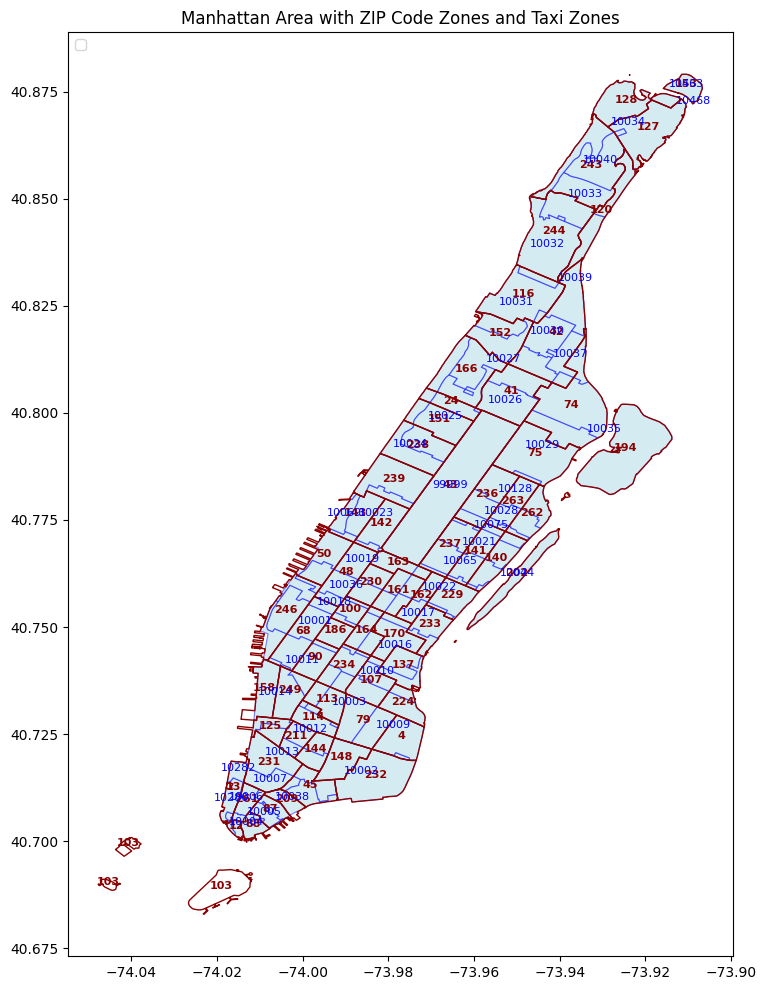

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the NYC taxi zones shapefile and reproject to EPSG:4326 (WGS84)
taxi_zones_gdf = gpd.read_file('data/raw/taxi_zones/taxi_zones.shp').to_crs(epsg=4326)

# Filter to only include Manhattan zones
manhattan_taxi_zones_gdf = taxi_zones_gdf[taxi_zones_gdf['borough'] == 'Manhattan'].copy()

# Load the ZIP code GeoDataFrame created from the CSV file and reproject to EPSG:4326
zip_codes_gdf = gpd.GeoDataFrame(zip_codes_df, geometry='geometry', crs="EPSG:4326")

# Remove any invalid geometries
manhattan_taxi_zones_gdf = manhattan_taxi_zones_gdf[manhattan_taxi_zones_gdf.is_valid]
zip_codes_gdf = zip_codes_gdf[zip_codes_gdf.is_valid]

# Perform a spatial overlay for the intersection
manhattan_zip_codes_gdf = gpd.overlay(zip_codes_gdf, manhattan_taxi_zones_gdf, how='intersection')

# Group by ZIP code to get the combined geometry for each unique ZIP code area
unique_zip_codes_gdf = manhattan_zip_codes_gdf.dissolve(by='MODZCTA', as_index=False)

# Plot the map
fig, ax = plt.subplots(figsize=(12, 12))

# Plot ZIP code zones with a light color
manhattan_zip_codes_gdf.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, linewidth=0.8, label='ZIP Code Zones')

# Plot taxi zones with a transparent fill and darker edge color
manhattan_taxi_zones_gdf.plot(ax=ax, color='none', edgecolor='darkred', linewidth=1, label='Taxi Zones')

# Add annotations for Taxi Zone LocationID
for idx, row in manhattan_taxi_zones_gdf.iterrows():
    plt.annotate(text=row['LocationID'], 
                 xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 ha='center', color='darkred', fontsize=8, weight='bold')

# Add annotations for each unique ZIP code once, using the centroid of the combined geometry
for idx, row in unique_zip_codes_gdf.iterrows():
    plt.annotate(text=row['MODZCTA'], 
                 xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 ha='center', color='blue', fontsize=8)

# Set aspect ratio to 'equal'
ax.set_aspect('equal')

# Add title and legend
plt.title("Manhattan Area with ZIP Code Zones and Taxi Zones")
plt.legend(loc='upper left')

# Show the plot
plt.show()


## 3. EV Registeration for Taxi Zones

- **Filter Manhattan Taxi Zones**:
  - Loads NYC taxi zones shapefile and filters for zones located in Manhattan.
  - Ensures the dataset uses the WGS84 coordinate reference system (EPSG:4326).

- **Prepare ZIP Code Data**:
  - Loads a GeoDataFrame of ZIP codes and ensures it uses the same CRS (EPSG:4326).

- **Process EV Registrations**:
  - Loads a CSV file of EV registrations and counts the number of EVs for each ZIP code.

- **Merge EV Counts with ZIP Code Data**:
  - Joins the EV counts with the ZIP code GeoDataFrame using the ZIP code as a key.
  - Fills missing values for ZIP codes without EV registrations with `0`.

- **Calculate Geometric Areas**:
  - Computes the area of each ZIP code geometry and each Manhattan taxi zone geometry.

- **Spatial Intersection**:
  - Calculates the intersection areas between Manhattan taxi zones and ZIP code zones.

- **Proportional EV Count Allocation**:
  - Calculates the proportion of each ZIP code's EV count corresponding to the intersected area within a taxi zone.
  - Adjusts the EV count for each taxi zone based on the area proportion.

- **Aggregate EV Counts by Taxi Zone**:
  - Sums the adjusted EV counts for all intersections within each taxi zone to estimate the total number of EVs for each taxi zone.

- **Output Results**:
  - Saves the estimated EV counts for each taxi zone to a CSV file named `taxi_zone_ev_counts.csv` for further use.


In [4]:
import geopandas as gpd
import pandas as pd

# Load the NYC taxi zones and ZIP code GeoDataFrames
taxi_zones_gdf = gpd.read_file('data/raw/taxi_zones/taxi_zones.shp').to_crs(epsg=4326)
manhattan_taxi_zones_gdf = taxi_zones_gdf[taxi_zones_gdf['borough'] == 'Manhattan'].copy()

# Load the ZIP code GeoDataFrame and reproject to EPSG:4326
zip_codes_gdf = gpd.GeoDataFrame(zip_codes_df, geometry='geometry', crs="EPSG:4326")

# Load the EV registrations CSV and count EVs by ZIP Code
ev_registrations_df = pd.read_csv('data/raw/ev_registerations/ny_ev_registrations.csv')
ev_count_by_zip = ev_registrations_df.groupby('ZIP Code').size().reset_index(name='EV_Count')

# Merge EV counts with ZIP code GeoDataFrame
zip_codes_gdf = zip_codes_gdf.merge(ev_count_by_zip, left_on='MODZCTA', right_on='ZIP Code', how='left')
zip_codes_gdf['EV_Count'] = zip_codes_gdf['EV_Count'].fillna(0)  # Fill NaN with 0 for ZIP codes without EVs

# Calculate area for each ZIP code geometry and taxi zone geometry
zip_codes_gdf['zip_area'] = zip_codes_gdf.geometry.area
manhattan_taxi_zones_gdf['taxi_zone_area'] = manhattan_taxi_zones_gdf.geometry.area

# Calculate intersection areas between taxi zones and ZIP code zones
intersection_gdf = gpd.overlay(manhattan_taxi_zones_gdf, zip_codes_gdf, how='intersection')
intersection_gdf['intersection_area'] = intersection_gdf.geometry.area

# Calculate the proportion of each ZIP code's EV count that belongs to the intersected area of each taxi zone
intersection_gdf['area_ratio'] = intersection_gdf['intersection_area'] / intersection_gdf['zip_area']
intersection_gdf['adjusted_ev_count'] = intersection_gdf['EV_Count'] * intersection_gdf['area_ratio']

# Sum adjusted EV counts for each taxi zone
ev_count_by_taxi_zone = intersection_gdf.groupby('LocationID')['adjusted_ev_count'].sum().reset_index()
ev_count_by_taxi_zone.rename(columns={'adjusted_ev_count': 'Estimated_EV_Count'}, inplace=True)

# Optionally save to CSV
ev_count_by_taxi_zone.to_csv("data/processed/ev_counts_taxi_zones/taxi_zone_ev_counts.csv", index=False)


/tmp/ipykernel_114320/2302016182.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zip_codes_gdf['zip_area'] = zip_codes_gdf.geometry.area
/tmp/ipykernel_114320/2302016182.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  manhattan_taxi_zones_gdf['taxi_zone_area'] = manhattan_taxi_zones_gdf.geometry.area
/tmp/ipykernel_114320/2302016182.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection_gdf['intersection_area'] = intersection_gdf.geometry.area


## 4. Charging Stations for Taxi Zones

- **Filter Manhattan Taxi Zones**:
  - Loads NYC taxi zones shapefile.
  - Filters the dataset to include only taxi zones in Manhattan.
  - Ensures the dataset uses the WGS84 coordinate reference system (EPSG:4326).

- **Load and Process EV Charging Station Data**:
  - Loads the EV charging stations dataset from a CSV file.
  - Calculates the total number of charging piles (`Total_Piles`) for each station by summing Level 1, Level 2, and DC Fast charging piles.

- **Convert Charging Station Data to GeoDataFrame**:
  - Creates a geometry column using the latitude and longitude for each charging station.
  - Converts the dataset into a GeoDataFrame with CRS set to WGS84 (EPSG:4326).

- **Spatial Join**:
  - Maps each charging station to the Manhattan taxi zone it is located within using a spatial join.

- **Aggregate Pile Counts by Taxi Zone**:
  - Groups the spatially joined data by taxi zone (`LocationID`).
  - Sums the total number of charging piles for all stations in each taxi zone.
  - Ensures all taxi zones, including those with zero piles, are included in the final output.

- **Output Results**:
  - Displays the resulting DataFrame with `LocationID` and the total number of piles (`Total_Piles`) in each taxi zone.
  - Saves the result to a CSV file named `manhattan_taxi_zone_total_piles.csv` for further use.


In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the NYC taxi zones shapefile and filter to only include Manhattan zones
taxi_zones_gdf = gpd.read_file('data/raw/taxi_zones/taxi_zones.shp')
manhattan_taxi_zones_gdf = taxi_zones_gdf[taxi_zones_gdf['borough'] == 'Manhattan'].copy()
manhattan_taxi_zones_gdf = manhattan_taxi_zones_gdf.to_crs(epsg=4326)

# Load the EV charging stations dataset
charging_stations_df = pd.read_csv('data/raw/ev_charging_stations/Electric_Vehicle_Charging_Stations_in_New_York.csv')

# Calculate the total number of piles per station
charging_stations_df['Total_Piles'] = charging_stations_df[['EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count']].sum(axis=1)

# Create geometry for each charging station using latitude and longitude
charging_stations_df['geometry'] = charging_stations_df.apply(
    lambda row: Point(row['Longitude'], row['Latitude']), axis=1
)

# Convert to GeoDataFrame
charging_stations_gdf = gpd.GeoDataFrame(charging_stations_df, geometry='geometry', crs="EPSG:4326")

# Perform a spatial join to assign each station's pile count to a taxi zone
stations_in_zones = gpd.sjoin(charging_stations_gdf, manhattan_taxi_zones_gdf, how="inner", predicate="within")

# Sum the total piles by taxi zone
pile_counts_by_zone = stations_in_zones.groupby('LocationID')['Total_Piles'].sum().reindex(
    manhattan_taxi_zones_gdf['LocationID'].unique(), fill_value=0
).reset_index(name='Total_Piles')

# Optionally save the result to a CSV file
pile_counts_by_zone.to_csv("data/processed/ev_charging_stations_taxi_zones/manhattan_taxi_zone_total_piles.csv", index=False)


## 5. Queue Parameters



In [13]:
import pandas as pd

# Assume `ev_count_by_taxi_zone` contains the EV counts for each taxi zone
# and `pile_counts_by_zone` contains the pile counts for each taxi zone

# Create a DataFrame for the 17-node graph node mappings
node_mapping_df = pd.DataFrame(list(location_id_map.items()), columns=['LocationID', 'NodeID'])

# Filter EV counts and pile counts to include only the 17 nodes in the graph
ev_count_17_nodes = ev_count_by_taxi_zone[ev_count_by_taxi_zone['LocationID'].isin(location_id_map.keys())]
pile_count_17_nodes = pile_counts_by_zone[pile_counts_by_zone['LocationID'].isin(location_id_map.keys())]

# Merge EV count and pile count data with the node mapping to align with sequential NodeID
ev_count_17_nodes = ev_count_17_nodes.merge(node_mapping_df, on='LocationID')
pile_count_17_nodes = pile_count_17_nodes.merge(node_mapping_df, on='LocationID')

# Rename columns for clarity
ev_count_17_nodes = ev_count_17_nodes.rename(columns={'Estimated_EV_Count': 'EV_Count'})
pile_count_17_nodes = pile_count_17_nodes.rename(columns={'Total_Piles': 'Pile_Count'})

# Merge the EV and pile count data by NodeID to get a final DataFrame with EV and pile counts for each node
final_count_df = pd.merge(ev_count_17_nodes[['NodeID', 'EV_Count']], pile_count_17_nodes[['NodeID', 'Pile_Count']], on='NodeID', how='left')

# Fill any NaN values with 0 for nodes with no EVs or piles
final_count_df = final_count_df.fillna(0)

# Sort by NodeID for easy reading
final_count_df = final_count_df.sort_values('NodeID').reset_index(drop=True)

# Optionally save to CSV
final_count_df.to_csv("data/processed/queue/node_arrival_service_rates.csv", index=False)

# Round EV_Count and convert to integer
final_count_df['EV_Count'] = final_count_df['EV_Count'].round()

# Add 4 to each Pile_Count
final_count_df['Pile_Count'] = (final_count_df['Pile_Count'] + 4).astype(int)

# Calculate the arrival rate as updated EV_Count divided by 96 and add as new column
final_count_df['Arrival_Rate'] = (final_count_df['EV_Count'] / 72).round(2)

# Display the modified DataFrame
final_count_df


,NodeID,EV_Count,Pile_Count,Arrival_Rate
0,0,1091.0,4,15.15
1,1,1330.0,10,18.47
2,2,1766.0,8,24.53
3,3,32.0,4,0.44
4,4,6650.0,29,92.36
5,5,1171.0,45,16.26
6,6,1000.0,4,13.89
7,7,382.0,4,5.31
8,8,288.0,4,4.00
9,9,2334.0,41,32.42


## 6. Order Selection

- **Load Green Taxi Data**:
  - Reads green taxi trip data for January 2024 from a Parquet file into a Pandas DataFrame.

- **Map Location IDs to Sequential Node IDs**:
  - Maps `PULocationID` (pickup location) and `DOLocationID` (drop-off location) to sequential node IDs in the graph using `location_id_map`.
  - Creates new columns `PU_node` and `DO_node` for the mapped values.

- **Filter Invalid Locations**:
  - Filters out rows where either the pickup (`PU_node`) or drop-off (`DO_node`) location is not present in the graph nodes (`NaN` values after mapping).

- **Convert Data Types**:
  - Converts `PU_node` and `DO_node` columns to integers for valid indexing.

- **Apply Additional Filtering Criteria**:
  - Excludes trips where:
    1. Pickup and drop-off locations are the same.
    2. Pickup time is after drop-off time.
    3. Trip distance is zero or negative.
    4. Passenger count exceeds 4.

- **Select Relevant Columns**:
  - Extracts columns for pickup datetime (`lpep_pickup_datetime`), pickup node (`PU_node`), and drop-off node (`DO_node`) for further analysis.

- **Save Processed Data**:
  - Saves the filtered and processed green taxi trip data to a CSV file named `green_taxi_orders.csv`.


In [14]:
import pandas as pd

# Load the data
df = pd.read_parquet('data/raw/taxi_data/green_tripdata_2024-01.parquet', engine='pyarrow')

# Map the PULocationID and DOLocationID columns to the sequential node IDs in the graph using the location_id_map
df['PU_node'] = df['PULocationID'].map(location_id_map)
df['DO_node'] = df['DOLocationID'].map(location_id_map)

# Filter out rows where PU or DO locations are outside the mapped graph nodes (i.e., NaN values after mapping)
df_filtered = df[(df['PU_node'].notna()) & (df['DO_node'].notna())]

# Convert the NaN values to integers for valid indexing
df_filtered['PU_node'] = df_filtered['PU_node'].astype(int)
df_filtered['DO_node'] = df_filtered['DO_node'].astype(int)

# Further filtering criteria:
# 1. Exclude rows where PU_node and DO_node are the same.
# 2. Ensure pickup time is before dropoff.
# 3. Ensure non-zero trip distance.
# 4. Limit passenger count to no more than 4.

df_filtered = df_filtered[
    (df_filtered['PU_node'] != df_filtered['DO_node']) &
    (df_filtered['lpep_pickup_datetime'] < df_filtered['lpep_dropoff_datetime']) &
    (df_filtered['trip_distance'] > 0) &
    (df_filtered['passenger_count'] <= 4)
]

green_taxi_orders = df_filtered[['lpep_pickup_datetime', 'PU_node', 'DO_node', 'passenger_count']]

green_taxi_orders.to_csv('data/processed/taxi_green_tripdata_2024-01/green_taxi_orders_2024_01.csv', index=False, header=True)


/tmp/ipykernel_114320/372719564.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PU_node'] = df_filtered['PU_node'].astype(int)
/tmp/ipykernel_114320/372719564.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['DO_node'] = df_filtered['DO_node'].astype(int)


- **Load Dataset**:
  - Reads the filtered green taxi orders dataset from `green_taxi_orders.csv`, parsing the pickup datetime column as a `datetime` object.

- **Set Day and Time Interval**:
  - Defines the day (`2024-01-01`) and time interval length (15 minutes) for analysis.

- **Filter Orders for the Day**:
  - Filters the dataset to include only trips that occurred on the specified day.

- **Create Time Intervals**:
  - Assigns each order to a 15-minute time interval based on the pickup time (`lpep_pickup_datetime`).

- **Group and Aggregate Orders**:
  - Groups orders by time intervals and pickup (`PU_node`) or drop-off (`DO_node`) nodes.
  - Counts the number of orders per node for each time interval, filling missing values with zero.

- **Ensure Complete Node Columns**:
  - Ensures all graph nodes are included in the aggregated data, even if some nodes have zero orders.

- **Customize Font Sizes**:
  - Sets font sizes for titles, labels, and ticks for better readability in the visualizations.

- **Generate Pickup Heatmap**:
  - Creates a heatmap showing the number of orders departing from each pickup node (PU) during each time interval.
  - Labels x-axis ticks with the starting time of each interval and adjusts layout for better visualization.

- **Generate Drop-Off Heatmap**:
  - Creates a heatmap showing the number of orders arriving at each drop-off node (DO) during each time interval.
  - Labels x-axis ticks with the starting time of each interval and adjusts layout for better visualization.

- **Visualize**:
  - Two heatmaps are generated:
    1. Pickup (PU) counts heatmap with a blue color scheme.
    2. Drop-off (DO) counts heatmap with a red-orange color scheme.

/tmp/ipykernel_114320/4252236094.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_on_day['time_interval'] = orders_on_day['lpep_pickup_datetime'].dt.floor(f'{interval_length.seconds//60}T')


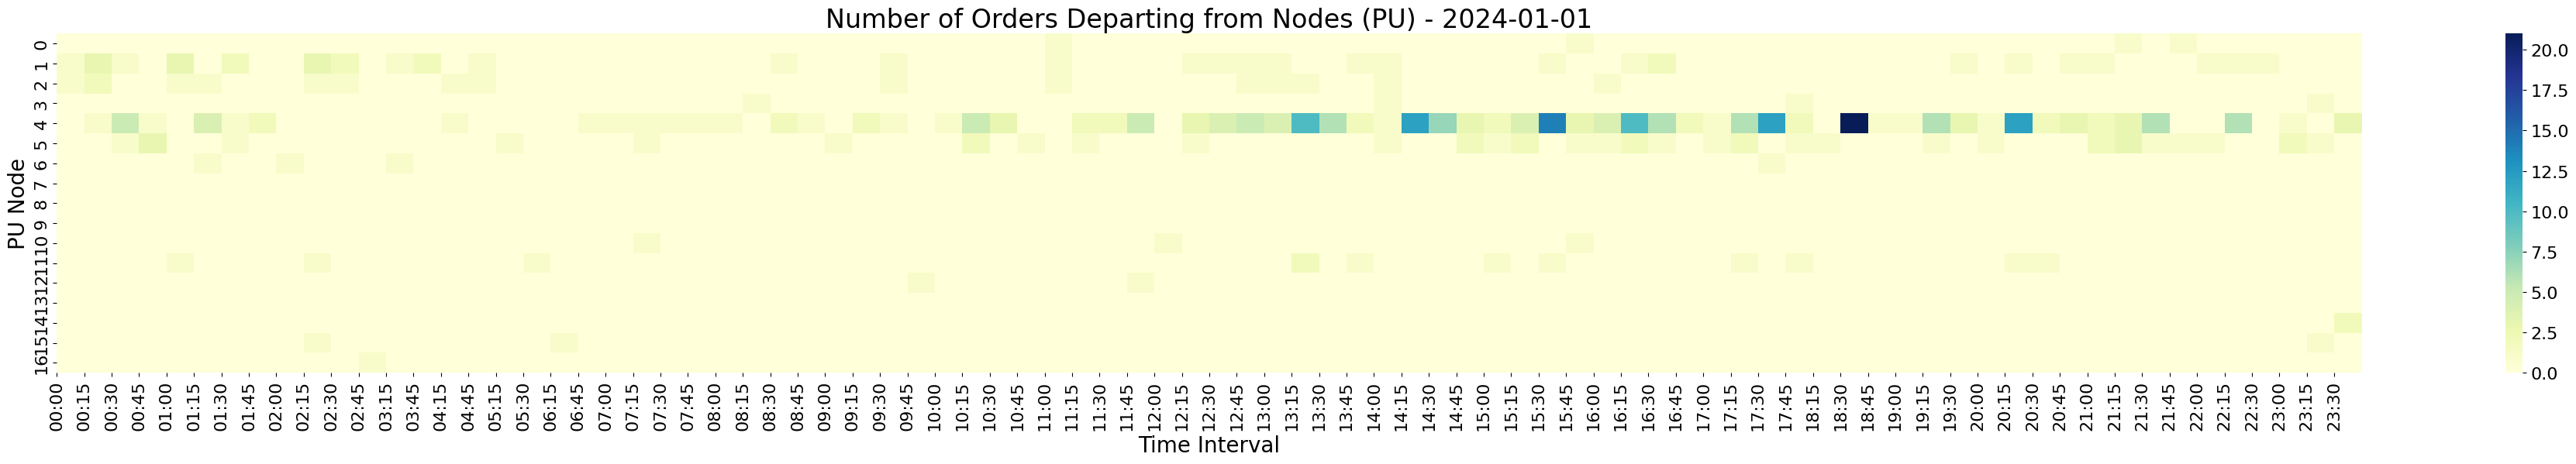

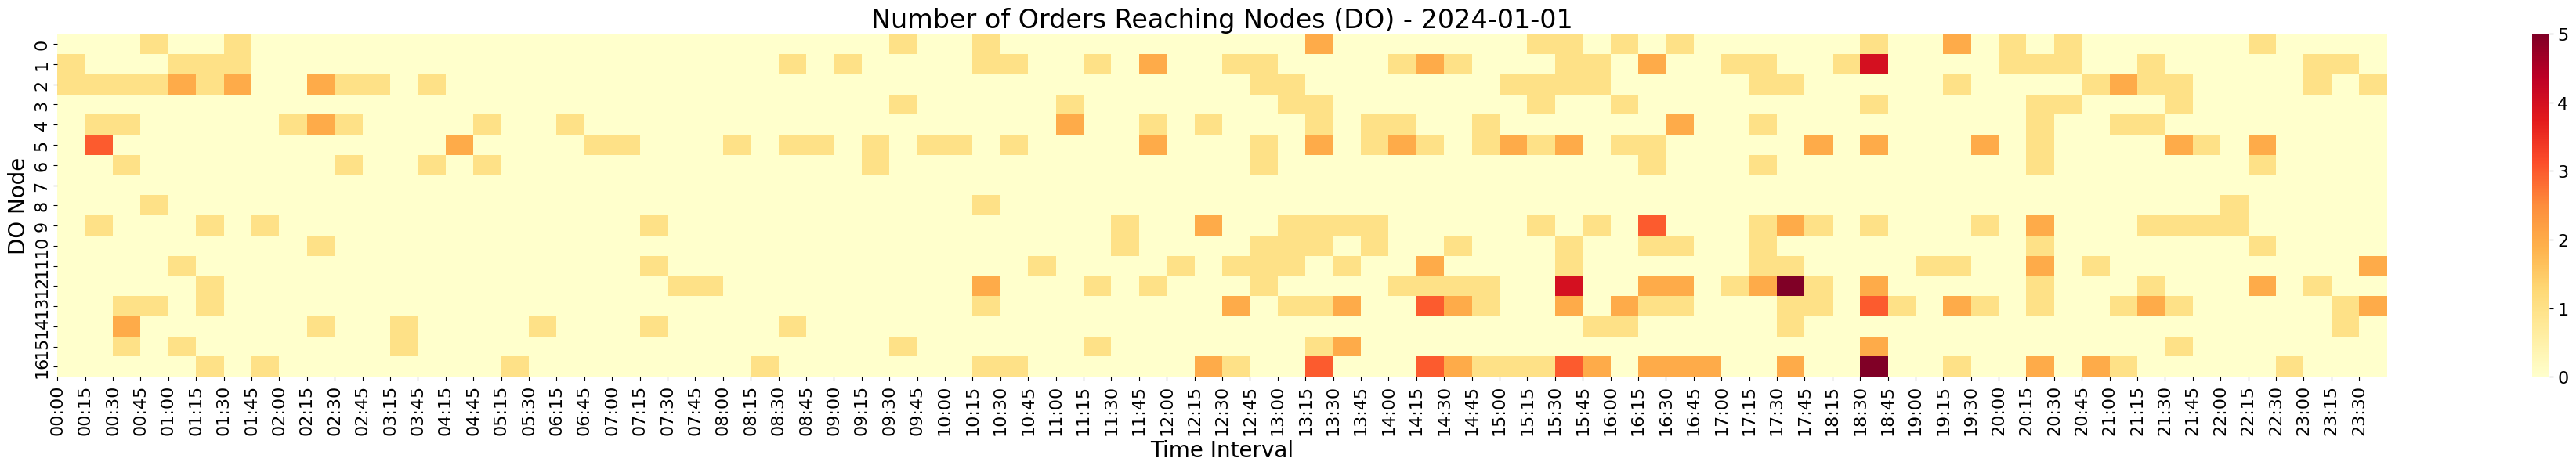

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the filtered green taxi orders dataset
green_taxi_orders = pd.read_csv('data/processed/taxi_green_tripdata_2024-01/green_taxi_orders_2024_01.csv', parse_dates=['lpep_pickup_datetime'])

# Define the day and time interval length
day = '2024-01-01'
interval_length = pd.Timedelta(minutes=15)  # 15-minute interval

# Filter orders for the specific day
orders_on_day = green_taxi_orders[green_taxi_orders['lpep_pickup_datetime'].dt.date == pd.to_datetime(day).date()]

# Create time intervals based on the interval length
orders_on_day['time_interval'] = orders_on_day['lpep_pickup_datetime'].dt.floor(f'{interval_length.seconds//60}T')

# Group by intervals and nodes to count orders for each pickup and drop-off node in each interval
pu_counts = orders_on_day.groupby(['time_interval', 'PU_node']).size().unstack(fill_value=0)
do_counts = orders_on_day.groupby(['time_interval', 'DO_node']).size().unstack(fill_value=0)

# Ensure each node has a column, even if it has no orders in some intervals
all_nodes = sorted(green_taxi_orders['PU_node'].unique())
pu_counts = pu_counts.reindex(columns=all_nodes, fill_value=0)
do_counts = do_counts.reindex(columns=all_nodes, fill_value=0)

# Set font sizes for the plots
plt.rc('font', size=20)           # Controls default text size
plt.rc('axes', titlesize=24)       # Controls title font size
plt.rc('axes', labelsize=20)       # Controls axis label font size
plt.rc('xtick', labelsize=16)      # Controls x-tick label font size
plt.rc('ytick', labelsize=16)      # Controls y-tick label font size

# Generate the heat map for pickup (PU) counts
plt.figure(figsize=(38.4, 6.4))
sns.heatmap(pu_counts.T, cmap="YlGnBu", cbar=True, annot=False, fmt=".0f")
plt.title(f'Number of Orders Departing from Nodes (PU) - {day}')
plt.xlabel('Time Interval')
plt.ylabel('PU Node')

# Customize x-axis ticks to show only the starting time of each interval
plt.xticks(ticks=range(len(pu_counts.index)), labels=[time.strftime('%H:%M') for time in pu_counts.index])
plt.tight_layout()
plt.show()

# Generate the heat map for drop-off (DO) counts
plt.figure(figsize=(38.4, 6.4))
sns.heatmap(do_counts.T, cmap="YlOrRd", cbar=True, annot=False, fmt=".0f")
plt.title(f'Number of Orders Reaching Nodes (DO) - {day}')
plt.xlabel('Time Interval')
plt.ylabel('DO Node')

# Customize x-axis ticks to show only the starting time of each interval
plt.xticks(ticks=range(len(do_counts.index)), labels=[time.strftime('%H:%M') for time in do_counts.index])
plt.tight_layout()
plt.show()


## 7. Electricity Price Generation

- **Load Dataset**:
  - Reads electricity price data from a CSV file named `Day_ahead_Energy_Price.csv`.

- **Filter for N.Y.C. Zone**:
  - Filters the dataset to include only rows where the `Zone` column is `"N.Y.C."`.

- **Convert Date Column**:
  - Converts the `Date` column to a datetime format for easier manipulation and filtering.

- **Remove Duplicates**:
  - Drops duplicate rows to ensure data consistency.

- **Define Time Range**:
  - Specifies a desired time range from `2024-01-01 00:00:00` to `2024-01-01 23:00:00`.

- **Filter by Time Range**:
  - Filters the dataset to include only rows within the specified date and time range.

- **Save Filtered Data**:
  - Saves the filtered dataset to a CSV file named `day_ahead_electricity_price.csv` for further use.

- **Output**:
  - The resulting dataset contains electricity prices for the "N.Y.C." zone on January 1, 2024, within the specified time range.

In [10]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('data/raw/electricity_price_data/Day_ahead_Energy_Price.csv')

# Filter for rows where Zone is "N.Y.C."
df_filtered = df[df['Zone'] == "N.Y.C."].copy()

# Convert the Date column to datetime format
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'], format='%m/%d/%Y %I:%M:%S %p')

# Remove duplicate rows
df_filtered = df_filtered.drop_duplicates()

# Define the desired time range
start_date = '2024-01-01 00:00:00'
end_date = '2024-01-01 23:00:00'

# Filter the data for the specified date range
df_filtered = df_filtered[(df_filtered['Date'] >= start_date) & (df_filtered['Date'] <= end_date)]

df_filtered

df_filtered.to_csv('data/processed/electricity_price/day_ahead_electricity_price.csv', index=False, header=True)


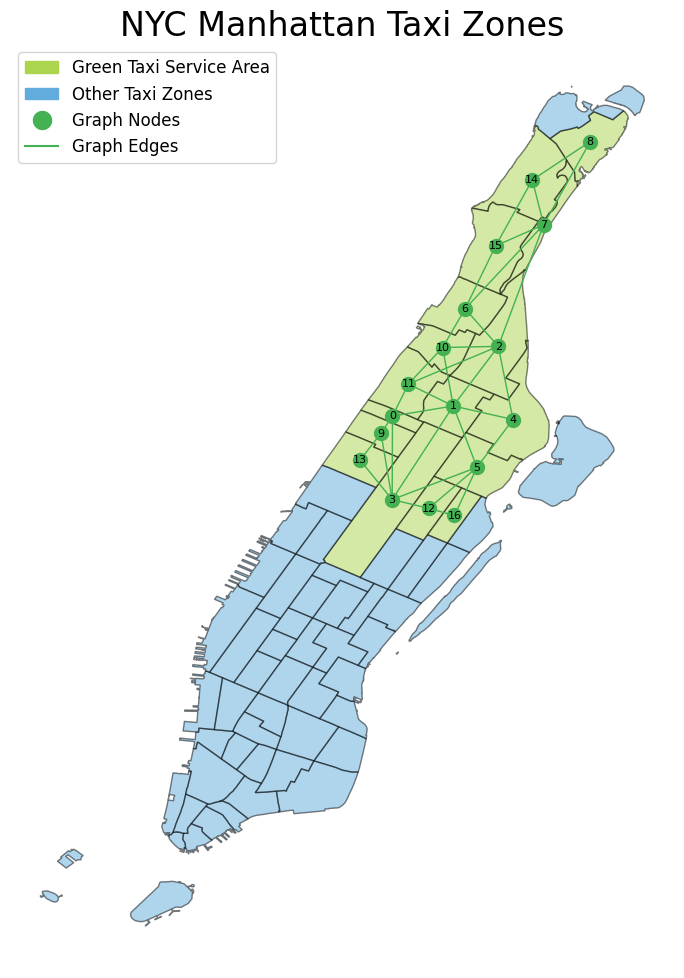

In [11]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from shapely.geometry import Point
from matplotlib.lines import Line2D

# Load the NYC taxi zones shapefile
taxi_zones_gdf = gpd.read_file('data/raw/taxi_zones/taxi_zones.shp')

# Filter to only include Manhattan zones
manhattan_taxi_zones_gdf = taxi_zones_gdf[taxi_zones_gdf['borough'] == 'Manhattan'].copy()
manhattan_taxi_zones_gdf = manhattan_taxi_zones_gdf.to_crs(epsg=4326)

# Create a set of node coordinates for quick lookup
node_coordinates = { (data['longitude'], data['latitude']): node for node, data in graph.nodes(data=True) }

# Function to determine if a taxi zone contains any node
def zone_contains_node(zone, node_coordinates):
    return any(zone.geometry.contains(Point(coord)) for coord in node_coordinates.keys())

# Assign colors based on whether the zone contains a node
manhattan_taxi_zones_gdf['color'] = manhattan_taxi_zones_gdf.apply(
    lambda row: '#abd54d' if zone_contains_node(row, node_coordinates) else '#61acdc', axis=1
)

# Create a figure
fig, ax = plt.subplots(figsize=(12, 12))

# Plot taxi zones with color based on node presence
manhattan_taxi_zones_gdf.plot(ax=ax, color=manhattan_taxi_zones_gdf['color'], edgecolor='black', alpha=0.5)

# Plot the 17-node graph
pos = {node: (data['longitude'], data['latitude']) for node, data in graph.nodes(data=True)}
nx.draw(graph, pos, with_labels=True, node_size=100, font_size=8, node_color='#44b152', edge_color='#44b152', ax=ax)

# Set aspect ratio to equal
ax.set_aspect('equal')

# Add title
plt.title("NYC Manhattan Taxi Zones")

# Create custom legend handles
# Create custom legend handles
legend_handles = [
    Patch(color='#abd54d', label='Green Taxi Service Area'),
    Patch(color='#61acdc', label='Other Taxi Zones'),
    Line2D([0], [0], marker='o', color='w', label='Graph Nodes', markerfacecolor='#44b152', markersize=15),
    Line2D([0], [0], color='#44b152', lw=1.5, label='Graph Edges')  # Line for edges
]

# Update legend
# Update legend
ax.legend(handles=legend_handles, loc='upper left', prop={'size': 12})  # Adjust font size

plt.savefig("NYC_map.svg", format="svg")

plt.show()


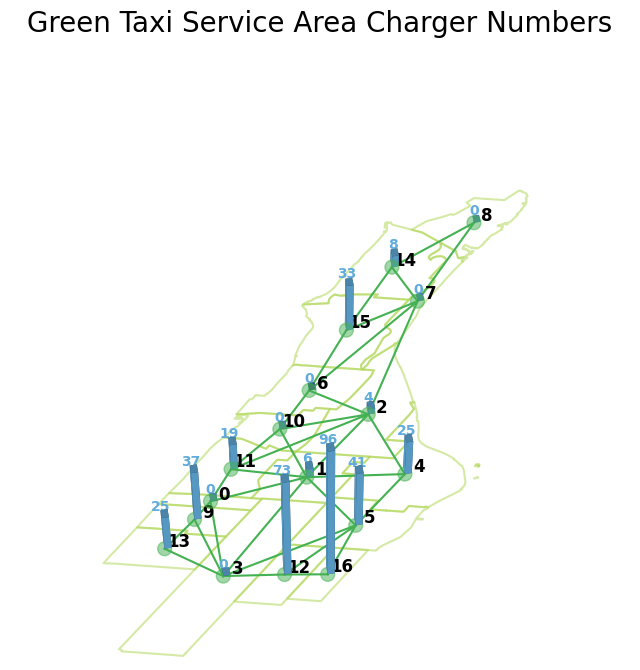

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

# Load the NYC taxi zones shapefile and filter to include only the Green Taxi Service Area zones
taxi_zones_gdf = gpd.read_file('data/raw/taxi_zones/taxi_zones.shp')
green_taxi_zones_gdf = taxi_zones_gdf[(taxi_zones_gdf['borough'] == 'Manhattan') & (taxi_zones_gdf['LocationID'].isin([74, 75, 43, 166, 41, 244, 42, 24, 116, 236, 152, 243, 263, 127, 120, 238, 151]))]
green_taxi_zones_gdf = green_taxi_zones_gdf.to_crs(epsg=4326)

# Assuming you have your graph and node positions already defined
# Use your existing graph 'graph' and positions
pos = {node: (data['longitude'], data['latitude']) for node, data in graph.nodes(data=True)}

# Values for charging piles
servers = [0, 6, 4, 0, 25, 41, 0, 0, 0, 37, 0, 19, 73, 25, 8, 33, 96]

# Create a new figure for 3D plotting with increased figure size
fig = plt.figure(figsize=(8, 20))  # Increase figure size for a larger map
ax = fig.add_subplot(111, projection='3d')

# Plot only the Green Taxi Service Area on the x-y plane
for _, zone in green_taxi_zones_gdf.iterrows():
    if isinstance(zone.geometry, Polygon):  # Single Polygon
        x_poly, y_poly = zone.geometry.exterior.xy
        ax.plot(x_poly, y_poly, zs=0, zdir='z', color='#abd54d', alpha=0.5)
    elif isinstance(zone.geometry, MultiPolygon):  # MultiPolygon
        for poly in zone.geometry.geoms:  # Use .geoms to iterate over MultiPolygon parts
            x_poly, y_poly = poly.exterior.xy
            ax.plot(x_poly, y_poly, zs=0, zdir='z', color='#abd54d', alpha=0.5)

# Extract x and y coordinates from the node positions
x = [pos[node][0] for node in graph.nodes()]
y = [pos[node][1] for node in graph.nodes()]
z = np.zeros(len(graph.nodes()))  # Base level for bars

# Plot the edges
for edge in graph.edges():
    x_edge = [pos[edge[0]][0], pos[edge[1]][0]]
    y_edge = [pos[edge[0]][1], pos[edge[1]][1]]
    z_edge = [0, 0]
    ax.plot(x_edge, y_edge, z_edge, color='#44b152', alpha=1)  # Edge color updated

# Plot the nodes
ax.scatter(x, y, z, color='#44b152', s=100, alpha=0.5)  # Node color updated

# Plot the bars for charging piles only
for i, server in enumerate(servers):
    # Plot each bar
    ax.bar3d(x[i], y[i], 0, 0.001, 0.002, server, color='#61acdc', alpha=1, label='Charging Piles' if i == 0 else "")
    # Annotate the charger count on top of each bar
    ax.text(x[i], y[i], server +6, f'{server}', color='#61acdc', ha='center', fontsize=10, weight='bold')

# Adjust node labels to appear next to the nodes
for i, (x_val, y_val) in enumerate(zip(x, y)):
    ax.text(x_val + 0.002, y_val, 0, f'{i}', color='black', fontsize=12, ha='center', weight='bold')

# Set title
ax.set_title("Green Taxi Service Area Charger Numbers", fontsize=20)

# Set axis limits to zoom in and enlarge the map
x_margin = 0  # Adjust this margin as needed
y_margin = 0
ax.set_xlim([min(x) - x_margin, max(x) + x_margin])
ax.set_ylim([min(y) - y_margin, max(y) + y_margin])

# Remove the axes for a cleaner look
ax.set_axis_off()

# Rotate the view to better align with the map's orientation
ax.view_init(elev=60, azim=260)  # Adjusted angles to match map orientation

plt.savefig("NYC_CS.svg", format="svg")

plt.show()
